<a href="https://colab.research.google.com/github/rafaelmgr12/ds-projects/blob/main/Home-Credit-Default-Risk/Home_Credit_Default_Risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Home Credit Default Risk
Can you predict how capable each applicant is of repaying a loan?

## Data Description
application_{train|test}.csv

This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
Static data for all applications. One row represents one loan in our data sample.
bureau.csv

All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.
bureau_balance.csv

Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.
POS_CASH_balance.csv

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.
credit_card_balance.csv

Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.
previous_application.csv

All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.
installments_payments.csv

Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.
HomeCredit_columns_description.csv

This file contains descriptions for the columns in the various data files.

<img src = "https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png" >

# Setup Google Collab

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
  from google.colab import files
  files.upload()
  ! mkdir ~/.kaggle
  ! wget https://raw.githubusercontent.com/rafaelmgr12/ds-projects/main/functions/ml_functions.py -O ml_functions.py
  ! wget https://raw.githubusercontent.com/rafaelmgr12/ds-projects/main/functions/plots_functions.py -O plot_functions.py
  ! pip install bayesian-optimization 
  ! pip install tensorflow==2.4
  ! pip install unidecode
  ! pip install category-encoders
  ! cp kaggle.json ~/.kaggle/
  ! chmod 600 ~/.kaggle/kaggle.json
  ! kaggle competitions download -c home-credit-default-risk
  ! unzip application_test.csv.zip
  ! unzip application_train.csv.zip
  ! unzip credit_card_balance.csv.zip
  ! unzip installments_payments.csv.zip
  ! unzip previous_application.csv.zip
  ! unzip bureau.csv.zip
  ! unzip bureau_balance.csv.zip
  ! unzip POS_CASH_balance.csv.zip

Saving kaggle.json to kaggle.json
--2021-06-17 13:17:24--  https://raw.githubusercontent.com/rafaelmgr12/ds-projects/main/functions/ml_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7181 (7.0K) [text/plain]
Saving to: ‘ml_functions.py’

ml_functions.py     100%[===================>]   7.01K  --.-KB/s    in 0s      

2021-06-17 13:17:24 (62.4 MB/s) - ‘ml_functions.py’ saved [7181/7181]

--2021-06-17 13:17:24--  https://raw.githubusercontent.com/rafaelmgr12/ds-projects/main/functions/plots_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awai

# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import time
from sklearn.preprocessing import LabelEncoder
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve,accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer as Imputer
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.style.use('ggplot')

import ml_functions as ml
import plot_functions as plf
# ml algorithims
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier,HistGradientBoostingClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
%matplotlib inline

In [3]:
## read the data
app_train = pd.read_csv('/content/application_train.csv')
app_test = pd.read_csv('/content/application_test.csv')
bureau = pd.read_csv('/content/bureau.csv')
bureau_bal = pd.read_csv('/content/bureau_balance.csv')
previous_app = pd.read_csv('/content/previous_application.csv')
pos_cash = pd.read_csv("/content/POS_CASH_balance.csv")
credit_bal = pd.read_csv("/content/credit_card_balance.csv")
instal_pay = pd.read_csv("/content/installments_payments.csv")

In [4]:
print('There are {} rows and {} columns in train'.format(app_train.shape[0],app_train.shape[1]))
print('There are {} rows and {} columns in train'.format(app_test.shape[0],app_test.shape[1]))

There are 307511 rows and 122 columns in train
There are 48744 rows and 121 columns in train


In [5]:
app_train.sample(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
135058,256638,0,Cash loans,M,Y,Y,2,360000.0,1921797.0,58396.5,1755000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.019101,-13473,-2450,-6314.0,-4436,8.0,1,1,0,1,0,0,Core staff,4.0,2,2,TUESDAY,14,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,-1565.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,5.0
44597,151664,0,Cash loans,F,N,Y,0,157500.0,284400.0,16456.5,225000.0,Family,Commercial associate,Higher education,Civil marriage,House / apartment,0.031329,-17849,-2303,-6580.0,-1393,NaN,1,1,0,1,0,0,Sales staff,2.0,2,2,FRIDAY,11,0,0,0,0,0,0,...,0.041,0.0389,0.0,0.0471,reg oper account,block of flats,0.0301,Panel,No,0.0,0.0,0.0,0.0,-1808.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
191346,321863,0,Cash loans,F,N,Y,1,157500.0,586764.0,22248.0,405000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.046220,-16814,-1243,-1278.0,-368,NaN,1,1,0,1,0,1,Sales staff,3.0,1,1,MONDAY,13,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-210.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
188577,318630,0,Cash loans,F,N,Y,1,180000.0,254700.0,16582.5,225000.0,Unaccompanied,Working,Secondary / secondary special,Separated,Rented apartment,0.009175,-10092,-508,-330.0,-341,NaN,1,1,1,1,0,0,NaN,2.0,2,2,WEDNESDAY,12,0,0,0,0,0,0,...,NaN,0.0665,NaN,0.0074,NaN,block of flats,0.0530,"Stone, brick",No,0.0,0.0,0.0,0.0,-283.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
232110,368848,0,Revolving loans,F,N,Y,0,81000.0,225000.0,11250.0,225000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,With parents,0.028663,-8512,-116,-2091.0,-1205,NaN,1,1,0,1,0,0,Medicine staff,1.0,2,2,TUESDAY,11,1,1,0,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-451.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
app_test.sample(5)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
4723,133972,Cash loans,F,N,Y,2,171000.0,550980.0,35343.0,450000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.007305,-13024,-1088,-4637.0,-458,NaN,1,1,0,1,1,0,Laborers,4.0,3,3,MONDAY,12,0,0,0,1,1,0,Business Entity Type 3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-2337.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
19048,238413,Cash loans,F,N,Y,0,99000.0,135000.0,14305.5,135000.0,Unaccompanied,Working,Higher education,Separated,House / apartment,0.018634,-16421,-3084,-7487.0,-4367,NaN,1,1,1,1,1,1,Managers,1.0,2,2,TUESDAY,14,0,0,0,0,0,0,Business Entity Type 1,...,NaN,0.0941,NaN,0.0795,NaN,block of flats,0.0959,"Stone, brick",No,0.0,0.0,0.0,0.0,-1274.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
38868,386281,Cash loans,F,N,N,0,67500.0,360000.0,15264.0,360000.0,Unaccompanied,Pensioner,Secondary / secondary special,Single / not married,House / apartment,0.018029,-22463,365243,-2507.0,-1847,NaN,1,0,0,1,0,0,NaN,1.0,3,3,SATURDAY,12,0,0,0,0,0,0,XNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1983.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
36270,365518,Cash loans,F,Y,Y,0,103500.0,675000.0,54252.0,675000.0,Unaccompanied,State servant,Secondary / secondary special,Married,House / apartment,0.010032,-9274,-808,-97.0,-1623,17.0,1,1,0,1,1,1,Medicine staff,2.0,2,2,MONDAY,4,0,0,0,0,0,0,School,...,NaN,0.0657,NaN,0.0024,NaN,block of flats,0.0508,Panel,No,7.0,0.0,7.0,0.0,-611.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
30083,318862,Cash loans,F,N,Y,1,103500.0,213322.5,12375.0,162000.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.009549,-13881,-1411,-3735.0,-3569,NaN,1,1,0,1,0,1,High skill tech staff,3.0,2,2,TUESDAY,12,0,0,0,0,0,0,Housing,...,NaN,0.0719,NaN,NaN,NaN,block of flats,0.0588,Panel,No,0.0,0.0,0.0,0.0,-1782.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0


# Exploratory Data Analysis

Exploratory Data Analysis (EDA) is an open-ended process where we calculate statistics and make figures to find trends, anomalies, patterns, or relationships within the data. 

## Examine the Distribution of the Target Column
The target is what we are asked to predict: either a 0 for the loan was repaid on time, or a 1 indicating the client had payment difficulties. We can first examine the number of loans falling into each category.

0    282686
1     24825
Name: TARGET, dtype: int64 



Text(0, 0.5, 'Samples')

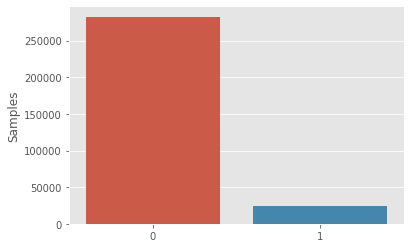

In [7]:
x=app_train.TARGET.value_counts()
sns.barplot(x.index,x)
print(x,'\n')
plt.gca().set_ylabel('Samples')

In [8]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

## Splitting the Data (Original DataFrame)
<a id="splitting"></a>
Before proceeding with the <b> Random UnderSampling technique</b> we have to separate the orginal dataframe. <b> Why? for testing purposes, remember although we are splitting the data when implementing Random UnderSampling or OverSampling techniques, we want to test our models on the original testing set not on the testing set created by either of these techniques.</b> The main goal is to fit the model either with the dataframes that were undersample and oversample (in order for our models to detect the patterns), and test it on the original testing set.  

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(app_train['TARGET'].value_counts()[0]/len(app_train) * 100,2), '% of the dataset')
print('Frauds', round(app_train['TARGET'].value_counts()[1]/len(app_train) * 100,2), '% of the dataset')

X = app_train.drop('TARGET', axis=1)
y = app_train['TARGET']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 91.93 % of the dataset
Frauds 8.07 % of the dataset
Train: [ 61465  61466  61467 ... 307508 307509 307510] Test: [    0     1     2 ... 61814 61816 61828]
Train: [     0      1      2 ... 307508 307509 307510] Test: [ 61465  61466  61467 ... 123093 123094 123095]
Train: [     0      1      2 ... 307508 307509 307510] Test: [121993 122029 122030 ... 184624 184625 184626]
Train: [     0      1      2 ... 307508 307509 307510] Test: [183271 183273 183278 ... 246095 246097 246099]
Train: [     0      1      2 ... 246095 246097 246099] Test: [244997 245014 245015 ... 307508 307509 307510]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.91927125 0.08072875]
[0.91927092 0.08072908]


## Random Under-Sampling:

In this phase of the project we will implement "*Random Under Sampling*" which basically consists of removing data in order to have a more <b> balanced dataset </b> and thus avoiding our models to overfitting.


### Steps:
<ul>
<li>The first thing we have to do is determine how <b>imbalanced</b> is our class (use "value_counts()" on the class column to determine the amount for each label)  </li>
<li>Once we determine how many instances are considered <b>Non-repay loan </b> (Fraud = "1") , we should bring the <b>repay loan</b> to the same amount as fraud transactions (assuming we want a 50/50 ratio), this will be equivalent to 24825 cases of fraud and 24825 cases of Non-repay loan.  </li>
<li> After implementing this technique, we have a sub-sample of our dataframe with a 50/50 ratio with regards to our classes. Then the next step we will implement is to <b>shuffle the data</b> to see if our models can maintain a certain accuracy everytime we run this script.</li>
</ul>

**Note:** The main issue with "Random Under-Sampling" is that we run the risk that our classification models will not perform as accurate as we would like to since there is a great deal of <b>information loss</b> (bringing 24,825 Non-repay loan  from 307,511 non-fraud transaction)

In [10]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

df = app_train.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = app_train.loc[app_train['TARGET'] == 1]
non_fraud_df = app_train.loc[app_train['TARGET'] == 0][:24825]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=None)

new_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
257653,398158,1,Cash loans,M,N,Y,0,67500.0,314100.0,13963.5,225000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.006852,-15647,-1172,-8211.0,-4384,NaN,1,1,1,1,0,0,Laborers,1.0,3,3,TUESDAY,6,0,0,0,0,0,0,...,0.0599,0.0447,0.0,0.0000,reg oper account,block of flats,0.0662,Panel,No,0.0,0.0,0.0,0.0,-674.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
243522,381920,1,Cash loans,M,N,N,0,157500.0,450000.0,30442.5,450000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.028663,-21328,-3368,-4071.0,-4344,NaN,1,1,1,1,1,0,Drivers,2.0,2,2,THURSDAY,8,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1520.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
239903,377818,1,Cash loans,M,Y,N,1,135000.0,670500.0,39924.0,670500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.035792,-16614,-525,-9214.0,-148,8.0,1,1,0,1,1,0,Laborers,3.0,2,2,TUESDAY,12,0,0,0,0,0,0,...,0.0064,0.0033,0.0,0.0009,reg oper account,block of flats,0.0017,"Stone, brick",No,0.0,0.0,0.0,0.0,-140.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
242499,380709,1,Cash loans,F,N,Y,1,180000.0,227520.0,18103.5,180000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,With parents,0.006629,-11014,-4201,-2467.0,-2462,NaN,1,1,1,1,1,1,Sales staff,3.0,2,2,SUNDAY,6,0,0,0,0,0,0,...,NaN,0.0105,NaN,NaN,NaN,block of flats,0.0017,Wooden,Yes,7.0,1.0,7.0,1.0,-726.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
23769,127656,0,Cash loans,F,N,N,2,216000.0,1035832.5,30415.5,904500.0,Family,State servant,Secondary / secondary special,Married,House / apartment,0.019101,-13809,-5360,-2972.0,-2392,NaN,1,1,0,1,0,0,Laborers,4.0,2,2,MONDAY,18,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,-1571.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


###  Equally Distributing and Correlating: 
<a id="correlating"></a>
Now that we have our dataframe correctly balanced, we can go further with our <b>analysis</b> and <b>data preprocessing</b>.

Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: TARGET, dtype: float64


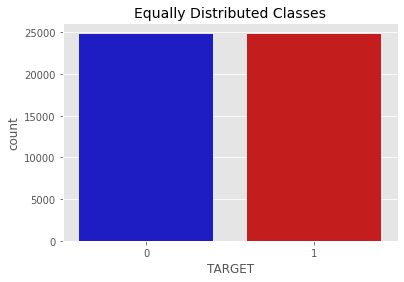

In [11]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['TARGET'].value_counts()/len(new_df))

colors = ["#0101DF", "#DF0101"]


sns.countplot('TARGET', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

<h3> Correlation Matrices </h3>
Correlation matrices are the essence of understanding our data. We want to know if there are features that influence heavily in whether a specific transaction is a fraud. However, it is important that we use the correct dataframe (subsample)  in order for us to see which features have a high positive or negative correlation with regards to fraud transactions.

### Summary and Explanation: 
<ul>
<li><b>Negative Correlations: </b>V17, V14, V12 and V10 are negatively correlated. Notice how the lower these values are, the more likely the end result will be a fraud transaction.  </li>
<li> <b> Positive Correlations: </b> V2, V4, V11, and V19 are positively correlated. Notice how the higher these values are, the more likely the end result will be a fraud transaction. </li>
<li> <b>BoxPlots: </b>  We will use boxplots to have a better understanding of the distribution of these features in fradulent and non fradulent transactions. </li>
</ul>


**Note: ** We have to make sure we use the subsample in our correlation matrix or else our correlation matrix will be affected by the high imbalance between our classes. This occurs due to the high class imbalance in the original dataframe.

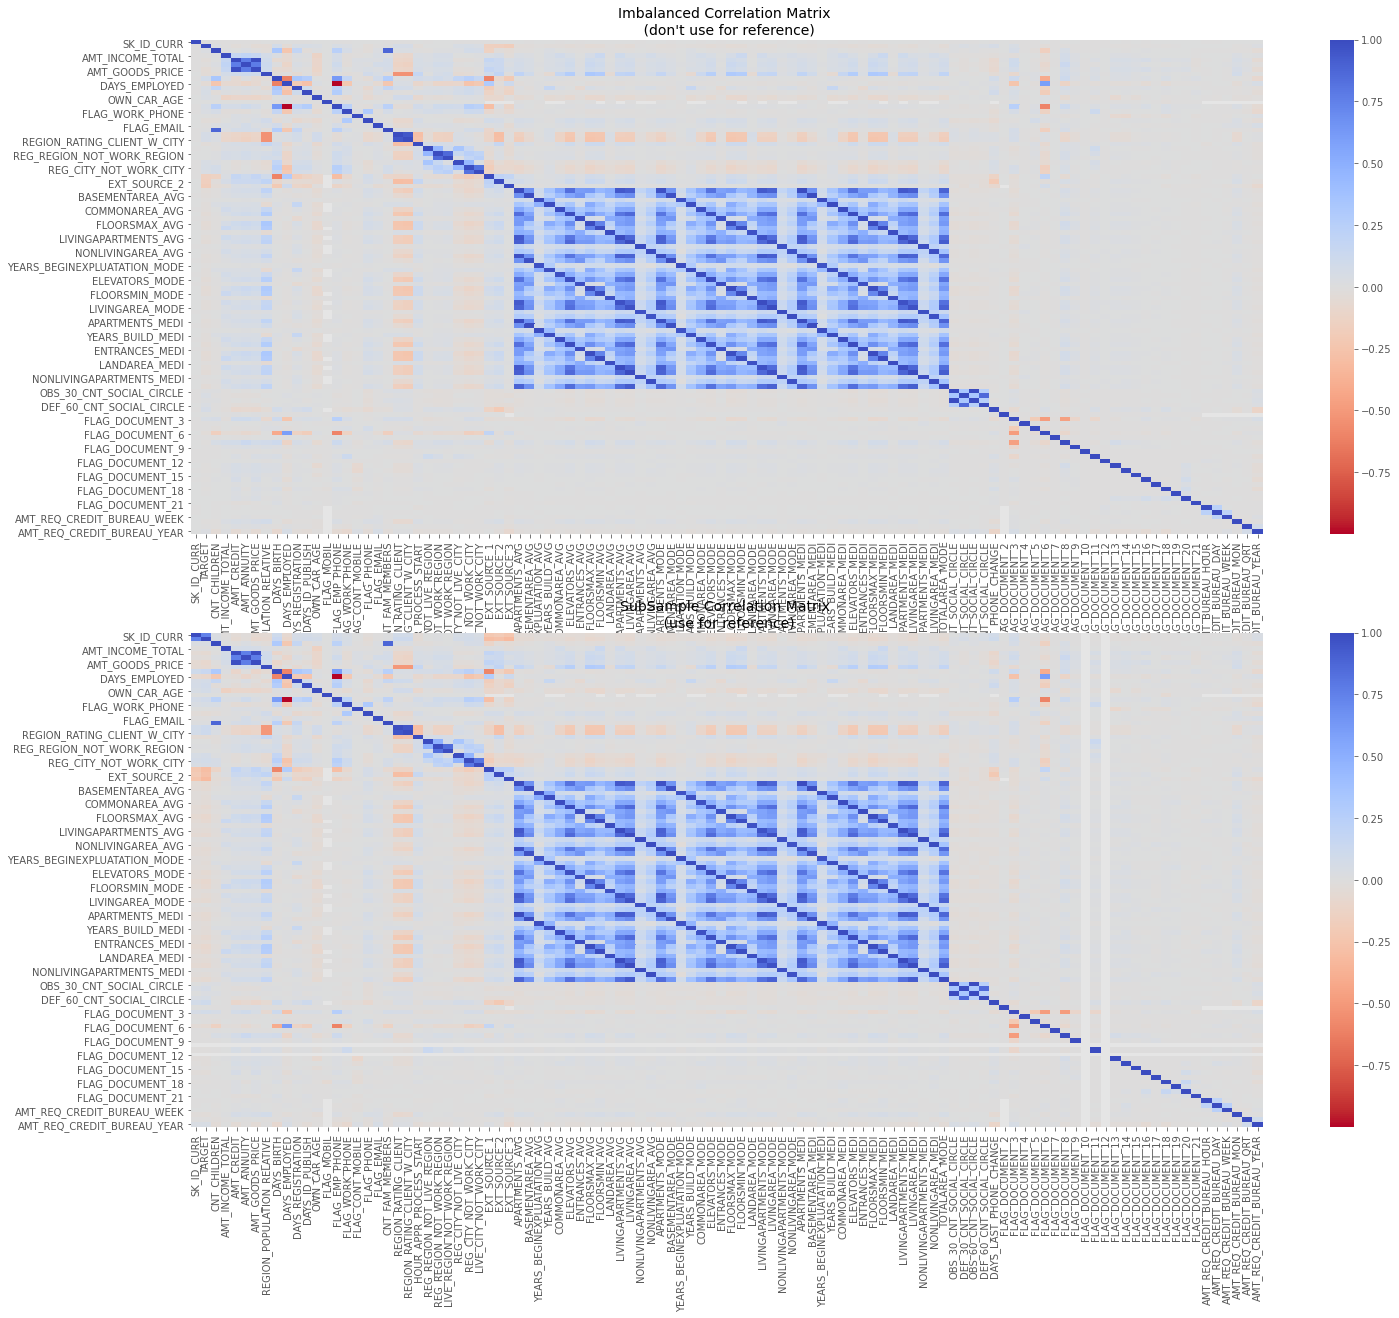

In [12]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = app_train.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':18}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':18}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

## Examine Missing Values
Next we can look at the number and percentage of missing values in each column.

In [13]:
missing_values = missing_values_table(new_df)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 65 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_AVG,35722,71.9
COMMONAREA_MODE,35722,71.9
COMMONAREA_MEDI,35722,71.9
NONLIVINGAPARTMENTS_MODE,35490,71.5
NONLIVINGAPARTMENTS_AVG,35490,71.5
NONLIVINGAPARTMENTS_MEDI,35490,71.5
FONDKAPREMONT_MODE,35035,70.6
LIVINGAPARTMENTS_MODE,35031,70.6
LIVINGAPARTMENTS_MEDI,35031,70.6
LIVINGAPARTMENTS_AVG,35031,70.6


When it comes time to build our machine learning models, we will have to fill in these missing values (known as imputation). In later work, we will use models such as XGBoost that can handle missing values with no need for imputation. Another option would be to drop columns with a high percentage of missing values, although it is impossible to know ahead of time if these columns will be helpful to our model. Therefore, we will keep all of the columns for now.

## Encoding Categorical Variables

Before we go any further, we need to deal with pesky categorical variables.  A machine learning model unfortunately cannot deal with categorical variables (except for some models such as [LightGBM](http://lightgbm.readthedocs.io/en/latest/Features.html)). Therefore, we have to find a way to encode (represent) these variables as numbers before handing them off to the model. There are two main ways to carry out this process:

* Label encoding: assign each unique category in a categorical variable with an integer. No new columns are created. An example is shown below

![image](https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/label_encoding.png)

* One-hot encoding: create a new column for each unique category in a categorical variable. Each observation recieves a 1 in the column for its corresponding category and a 0 in all other new columns. 

![image](https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/one_hot_encoding.png)

The problem with label encoding is that it gives the categories an arbitrary ordering. The value assigned to each of the categories is random and does not reflect any inherent aspect of the category. In the example above, programmer recieves a 4 and data scientist a 1, but if we did the same process again, the labels could be reversed or completely different. The actual assignment of the integers is arbitrary. Therefore, when we perform label encoding, the model might use the relative value of the feature (for example programmer = 4 and data scientist = 1) to assign weights which is not what we want. If we only have two unique values for a categorical variable (such as Male/Female), then label encoding is fine, but for more than 2 unique categories, one-hot encoding is the safe option.

There is some debate about the relative merits of these approaches, and some models can deal with label encoded categorical variables with no issues. [Here is a good Stack Overflow discussion](https://datascience.stackexchange.com/questions/9443/when-to-use-one-hot-encoding-vs-labelencoder-vs-dictvectorizor). I think (and this is just a personal opinion) for categorical variables with many classes, one-hot encoding is the safest approach because it does not impose arbitrary values to categories. The only downside to one-hot encoding is that the number of features (dimensions of the data) can explode with categorical variables with many categories. To deal with this, we can perform one-hot encoding followed by [PCA](http://www.cs.otago.ac.nz/cosc453/student_tutorials/principal_components.pdf) or other [dimensionality reduction methods](https://www.analyticsvidhya.com/blog/2015/07/dimension-reduction-methods/) to reduce the number of dimensions (while still trying to preserve information). 

In this notebook, we will use Label Encoding for any categorical variables with only 2 categories and One-Hot Encoding for any categorical variables with more than 2 categories. This process may need to change as we get further into the project, but for now, we will see where this gets us. (We will also not use any dimensionality reduction in this notebook but will explore in future iterations).

### Label Encoding and One-Hot Encoding

Let's implement the policy described above: for any categorical variable (`dtype == object`) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 2 unique categories, we will use one-hot encoding. 

For label encoding, we use the Scikit-Learn `LabelEncoder` and for one-hot encoding, the pandas `get_dummies(df)` function.

In [14]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in new_df:
    if new_df[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(new_df[col].unique())) <= 2:
            # Train on the training data
            le.fit(new_df[col])
            # Transform both training and testing data
            new_df[col] = le.transform(new_df[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

4 columns were label encoded.


In [15]:
# one-hot encoding of categorical variables
new_df = pd.get_dummies(new_df)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', new_df.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (49650, 239)
Testing Features shape:  (48744, 238)


### Aligning Training and Testing Data

There need to be the same features (columns) in both the training and testing data. One-hot encoding has created more columns in the training data because there were some categorical variables with categories not represented in the testing data. To remove the columns in the training data that are not in the testing data, we need to `align` the dataframes. First we extract the target column from the training data (because this is not in the testing data but we need to keep this information). When we do the align, we must make sure to set `axis = 1` to align the dataframes based on the columns and not on the rows!

In [64]:
train_labels = new_df['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
new_df, app_test = new_df.align(app_test, join = 'inner', axis = 1)

# Add the target back in
new_df['TARGET'] = train_labels

print('Training Features shape: ', new_df.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (49650, 239)
Testing Features shape:  (48744, 238)


## Back to Exploratory Data Analysis

### Anomalies

One problem we always want to be on the lookout for when doing EDA is anomalies within the data. These may be due to mis-typed numbers, errors in measuring equipment, or they could be valid but extreme measurements. One way to support anomalies quantitatively is by looking at the statistics of a column using the `describe` method. The numbers in the `DAYS_BIRTH` column are negative because they are recorded relative to the current loan application. To see these stats in years, we can mutliple by -1 and divide by the number of days in a year:



In [17]:
(new_df['DAYS_BIRTH'] / -365).describe()


count    49650.000000
mean        42.500192
std         11.842926
min         21.035616
25%         32.520548
50%         41.282192
75%         52.120548
max         68.991781
Name: DAYS_BIRTH, dtype: float64

Those ages look reasonable. There are no outliers for the age on either the high or low end. How about the days of employment?

In [18]:
new_df['DAYS_EMPLOYED'].describe()


count     49650.000000
mean      53887.704612
std      132074.634377
min      -16365.000000
25%       -2477.000000
50%       -1130.000000
75%        -338.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

That doesn't look right! The maximum value (besides being positive) is about 1000 years!



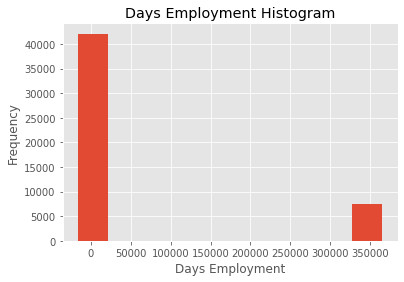

In [19]:
new_df['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

Just out of curiousity, let's subset the anomalous clients and see if they tend to have higher or low rates of default than the rest of the clients.



In [20]:
anom = new_df[new_df['DAYS_EMPLOYED'] == 365243]
non_anom = new_df[new_df['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 51.89% of loans
The anomalies default on 39.50% of loans
There are 7570 anomalous days of employment


Well that is extremely interesting! It turns out that the anomalies have a lower rate of default.

Handling the anomalies depends on the exact situation, with no set rules. One of the safest approaches is just to set the anomalies to a missing value and then have them filled in (using Imputation) before machine learning. In this case, since all the anomalies have the exact same value, we want to fill them in with the same value in case all of these loans share something in common. The anomalous values seem to have some importance, so we want to tell the machine learning model if we did in fact fill in these values. As a solution, we will fill in the anomalous values with not a number (np.nan) and then create a new boolean column indicating whether or not the value was anomalous.



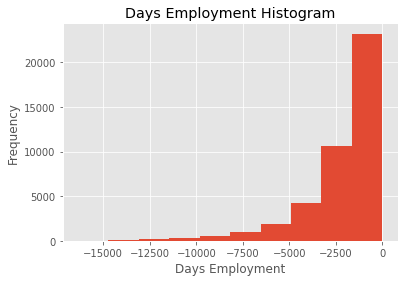

In [21]:
# Create an anomalous flag column
new_df['DAYS_EMPLOYED_ANOM'] = new_df["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
new_df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

new_df['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

The distribution looks to be much more in line with what we would expect, and we also have created a new column to tell the model that these values were originally anomalous (becuase we will have to fill in the nans with some value, probably the median of the column). The other columns with DAYS in the dataframe look to be about what we expect with no obvious outliers.

As an extremely important note, anything we do to the training data we also have to do to the testing data. Let's make sure to create the new column and fill in the existing column with np.nan in the testing data.

In [22]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))


There are 9274 anomalies in the test data out of 48744 entries


### Correlations

Now that we have dealt with the categorical variables and the outliers, let's continue with the EDA. One way to try and understand the data is by looking for correlations between the features and the target. We can calculate the Pearson correlation coefficient between every variable and the target using the `.corr` dataframe method.

The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data. Some [general interpretations of the absolute value of the correlation coefficent](http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf) are:


* .00-.19 “very weak”
*  .20-.39 “weak”
*  .40-.59 “moderate”
*  .60-.79 “strong”
* .80-1.0 “very strong”


In [23]:
 # Find correlations with the target and sort
correlations = new_df.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 REG_CITY_NOT_WORK_CITY                               0.084694
FLAG_EMP_PHONE                                       0.089128
DAYS_ID_PUBLISH                                      0.090552
NAME_EDUCATION_TYPE_Secondary / secondary special    0.097504
CODE_GENDER                                          0.098397
NAME_INCOME_TYPE_Working                             0.099387
DAYS_LAST_PHONE_CHANGE                               0.105134
REGION_RATING_CLIENT                                 0.112218
REGION_RATING_CLIENT_W_CITY                          0.115207
DAYS_BIRTH                                           0.145222
DAYS_EMPLOYED                                        0.149245
SK_ID_CURR                                           0.743804
TARGET                                               1.000000
FLAG_DOCUMENT_10                                          NaN
FLAG_DOCUMENT_12                                          NaN
Name: TARGET, dtype: float64

Most Negati

Let's take a look at some of more significant correlations: the `DAYS_BIRTH` is the most positive correlation. (except for `TARGET` because the correlation of a variable with itself is always 1!) Looking at the documentation, `DAYS_BIRTH` is the age in days of the client at the time of the loan in negative days (for whatever reason!). The correlation is positive, but the value of this feature is actually negative, meaning that as the client gets older, they are less likely to default on their loan (ie the target == 0). That's a little confusing, so we will take the absolute value of the feature and then the correlation will be negative.

In [24]:
# Find the correlation of the positive days since birth and target
new_df['DAYS_BIRTH'] = abs(new_df['DAYS_BIRTH'])
new_df['DAYS_BIRTH'].corr(new_df['TARGET'])

-0.1452224230809863

As the client gets older, there is a negative linear relationship with the target meaning that as clients get older, they tend to repay their loans on time more often. 

Let's start looking at this variable. First, we can make a histogram of the age. We will put the x axis in years to make the plot a little more understandable.

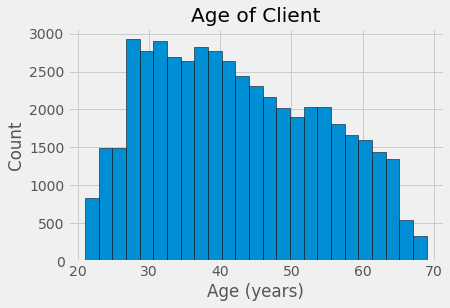

In [25]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(new_df['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

By itself, the distribution of age does not tell us much other than that there are no outliers as all the ages are reasonable. To visualize the effect of the age on the target, we will next make a [kernel density estimation plot](https://en.wikipedia.org/wiki/Kernel_density_estimation) (KDE) colored by the value of the target. A [kernel density estimate plot shows the distribution of a single variable](https://chemicalstatistician.wordpress.com/2013/06/09/exploratory-data-analysis-kernel-density-estimation-in-r-on-ozone-pollution-data-in-new-york-and-ozonopolis/) and can be thought of as a smoothed histogram (it is created by computing a kernel, usually a Gaussian, at each data point and then averaging all the individual kernels to develop a single smooth curve). We will use the seaborn `kdeplot` for this graph.

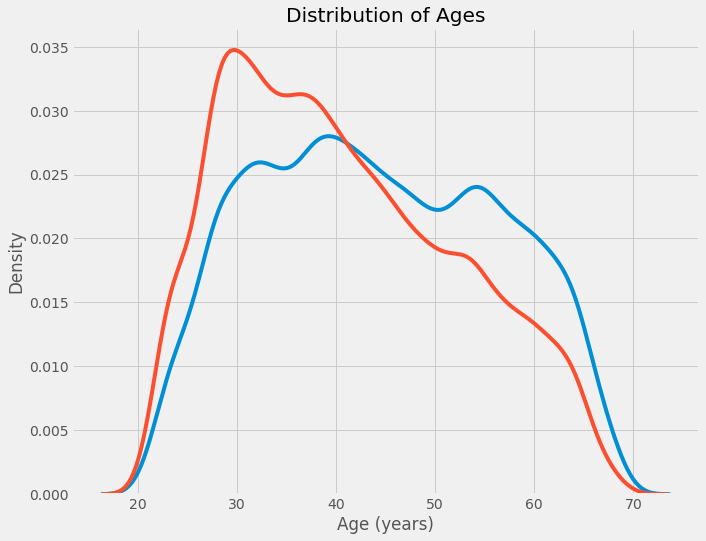

In [26]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(new_df.loc[new_df['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(new_df.loc[new_df['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

The target == 1 curve skews towards the younger end of the range. Although this is not a significant correlation (-0.07 correlation coefficient), this variable is likely going to be useful in a machine learning model because it does affect the target. Let's look at this relationship in another way: average failure to repay loans by age bracket. 

To make this graph, first we `cut` the age category into bins of 5 years each. Then, for each bin, we calculate the average value of the target, which tells us the ratio of loans that were not repaid in each age category.

In [27]:
# Age information into a separate dataframe
age_data = new_df[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
257653,1,15647,42.868493,"(40.0, 45.0]"
243522,1,21328,58.432877,"(55.0, 60.0]"
239903,1,16614,45.517808,"(45.0, 50.0]"
242499,1,11014,30.175342,"(30.0, 35.0]"
23769,0,13809,37.832877,"(35.0, 40.0]"
137889,1,20588,56.405479,"(55.0, 60.0]"
79958,1,20302,55.621918,"(55.0, 60.0]"
238385,1,10669,29.230137,"(25.0, 30.0]"
303464,1,12483,34.200000,"(30.0, 35.0]"
128394,1,12503,34.254795,"(30.0, 35.0]"


In [28]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.617671,8517.025599,23.334317
"(25.0, 30.0]",0.591122,10159.351897,27.833841
"(30.0, 35.0]",0.558771,11848.701667,32.462196
"(35.0, 40.0]",0.533324,13697.993043,37.528748
"(40.0, 45.0]",0.494221,15494.687044,42.451197
"(45.0, 50.0]",0.473560,17321.115755,47.455112
"(50.0, 55.0]",0.445290,19192.740438,52.582851
"(55.0, 60.0]",0.403880,20975.587522,57.467363
"(60.0, 65.0]",0.387537,22786.402781,62.428501


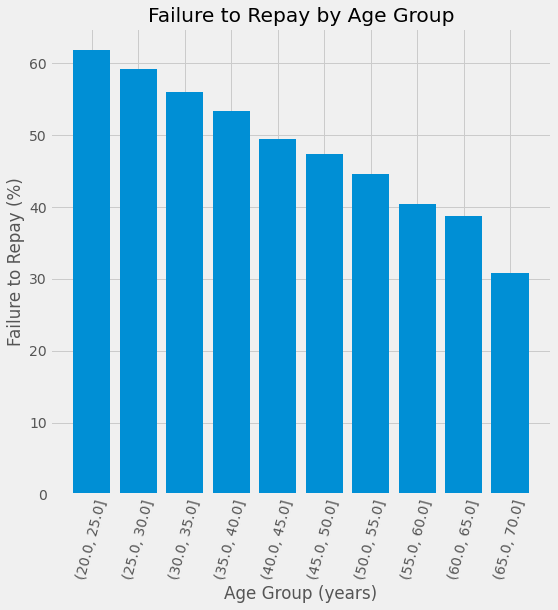

In [29]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

There is a clear trend: younger applicants are more likely to not repay the loan! The rate of failure to repay is above 10% for the youngest three age groups and beolow 5% for the oldest age group.

This is information that could be directly used by the bank: because younger clients are less likely to repay the loan, maybe they should be provided with more guidance or financial planning tips. This does not mean the bank should discriminate against younger clients, but it would be smart to take precautionary measures to help younger clients pay on time.



### Exterior Sources

The 3 variables with the strongest negative correlations with the target are `EXT_SOURCE_1`, `EXT_SOURCE_2`, and `EXT_SOURCE_3`.
According to the documentation, these features represent a "normalized score from external data source". I'm not sure what this exactly means, but it may be a cumulative sort of credit rating made using numerous sources of data. 

Let's take a look at these variables.

First, we can show the correlations of the `EXT_SOURCE` features with the target and with each other.

In [30]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = new_df[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.291715,-0.271615,-0.315436,-0.145222
EXT_SOURCE_1,-0.291715,1.000000,0.240511,0.229631,0.592150
EXT_SOURCE_2,-0.271615,0.240511,1.000000,0.155537,0.131243
EXT_SOURCE_3,-0.315436,0.229631,0.155537,1.000000,0.223458
DAYS_BIRTH,-0.145222,0.592150,0.131243,0.223458,1.000000


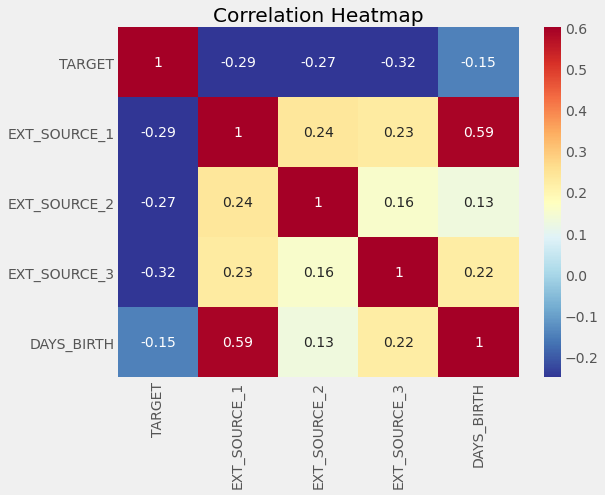

In [31]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');


All three `EXT_SOURCE` featureshave negative correlations with the target, indicating that as the value of the `EXT_SOURCE` increases, the client is more likely to repay the loan. We can also see that `DAYS_BIRTH` is positively correlated with `EXT_SOURCE_1` indicating that maybe one of the factors in this score is the client age.

Next we can look at the distribution of each of these features colored by the value of the target. This will let us visualize the effect of this variable on the target.

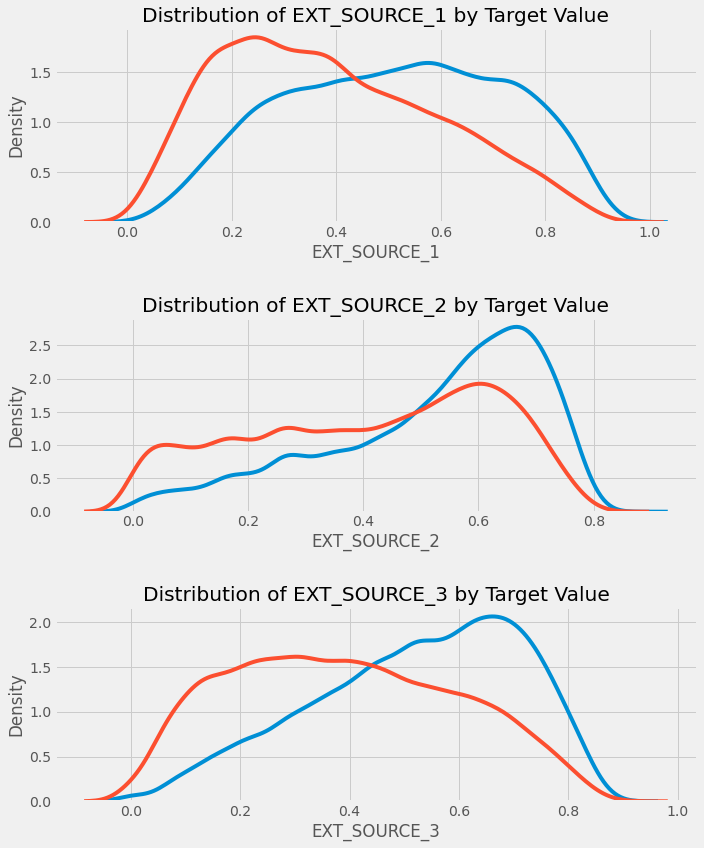

In [32]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(new_df.loc[new_df['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(new_df.loc[new_df['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)
    

`EXT_SOURCE_3` displays the greatest difference between the values of the target. We can clearly see that this feature has some relationship to the likelihood of an applicant to repay a loan. The relationship is not very strong (in fact they are all [considered very weak](http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf), but these variables will still be useful for a machine learning model to predict whether or not an applicant will repay a loan on time.

## Pairs Plot

As a final exploratory plot, we can make a pairs plot of the `EXT_SOURCE` variables and the `DAYS_BIRTH` variable. The [Pairs Plot](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166) is a great exploration tool because it lets us see relationships between multiple pairs of variables as well as distributions of single variables. Here we are using the seaborn visualization library and the PairGrid function to create a Pairs Plot with scatterplots on the upper triangle, histograms on the diagonal, and 2D kernel density plots and correlation coefficients on the lower triangle.

If you don't understand this code, that's all right! Plotting in Python can be overly complex, and for anything beyond the simplest graphs, I usually find an existing implementation and adapt the code (don't repeat yourself)! 

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1152: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1135: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1135: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1135: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1135: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1135: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserW

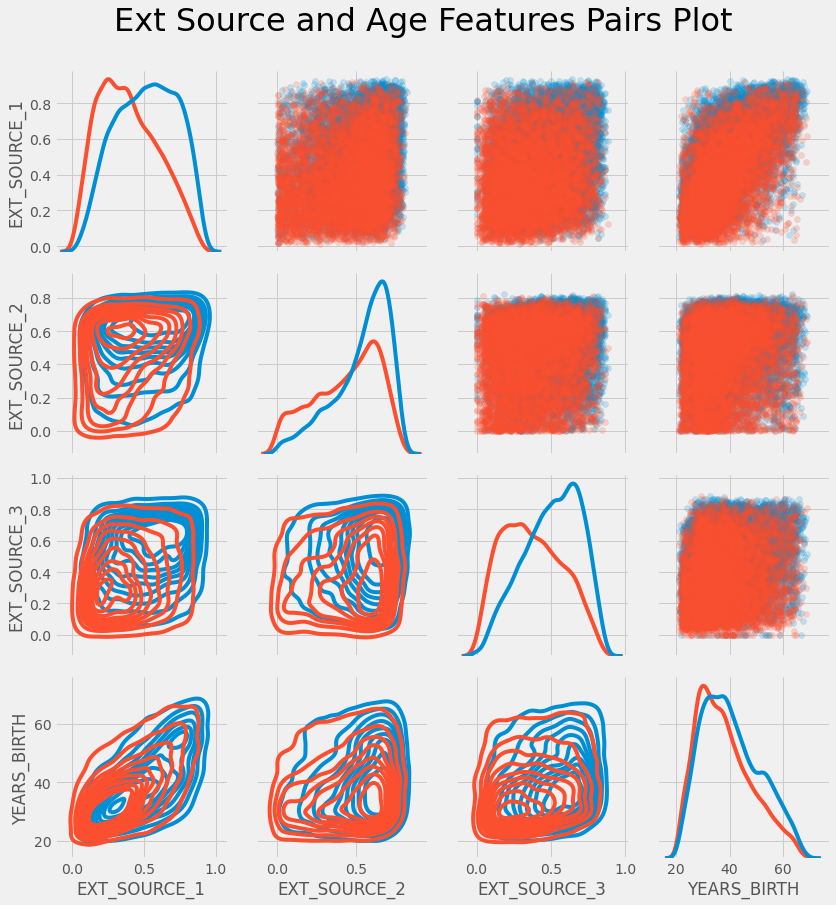

In [33]:
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().iloc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

# Baseline

For a naive baseline, we could guess the same value for all examples on the testing set.  We are asked to predict the probability of not repaying the loan, so if we are entirely unsure, we would guess 0.5 for all observations on the test set. This  will get us a Reciever Operating Characteristic Area Under the Curve (AUC ROC) of 0.5 in the competition ([random guessing on a classification task will score a 0.5](https://stats.stackexchange.com/questions/266387/can-auc-roc-be-between-0-0-5)).

Since we already know what score we are going to get, we don't really need to make a naive baseline guess. Let's use a slightly more sophisticated model for our actual baseline: Logistic Regression.

## Logistic Regression Implementation

Here I will focus on implementing the model rather than explaining the details, but for those who want to learn more about the theory of machine learning algorithms, I recommend both [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/) and [Hands-On Machine Learning with Scikit-Learn and TensorFlow](http://shop.oreilly.com/product/0636920052289.do). Both of these books present the theory and also the code needed to make the models (in R and Python respectively). They both teach with the mindset that the best way to learn is by doing, and they are very effective! 

To get a baseline, we will use all of the features after encoding the categorical variables. We will preprocess the data by filling in the missing values (imputation) and normalizing the range of the features (feature scaling). The following code performs both of these preprocessing steps.

In [34]:
from sklearn.preprocessing import StandardScaler

# Drop the target from the training data
if 'TARGET' in new_df:
    train = new_df.drop(columns = ['TARGET'])
else:
    train = new_df.copy()
    
# Feature names
features = list(train.columns)

# Copy of the testing data
test = app_test.copy()

# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Scale each feature to 0-1
scaler = StandardScaler()

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(app_test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (49650, 238)
Testing data shape:  (48744, 238)


In [35]:
# training split
X_train, X_test, y_train, y_test = ml.tts_split(train,train_labels.values, 0.3, 5)

We will use [`LogisticRegression`from Scikit-Learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for our first model. The only change we will make from the default model settings is to lower the [regularization parameter](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression), C, which controls the amount of overfitting (a lower value should decrease overfitting). This will get us slightly better results than the default `LogisticRegression`, but it still will set a low bar for any future models.

Here we use the familiar Scikit-Learn modeling syntax: we first create the model, then we train the model using `.fit` and then we make predictions on the testing data using `.predict_proba` (remember that we want probabilities and not a 0 or 1).

In [36]:
lr = ml.Class_Fit(clf = LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,20),
                              'penalty':['l1', 'l2', 'elasticnet', 'none']}], Kfold = 5)
lr.grid_fit(X = X_train, Y = y_train)
lr.grid_predict(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Precision: 94.36 %  
 ROC Score: 0.94

               precision    recall  f1-score   support

           0       0.91      0.98      0.95      7423
           1       0.98      0.91      0.94      7472

    accuracy                           0.94     14895
   macro avg       0.95      0.94      0.94     14895
weighted avg       0.95      0.94      0.94     14895



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


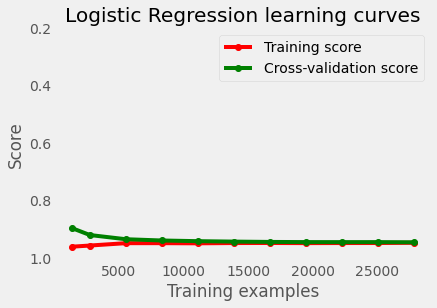

In [37]:
g = plf.plot_learning_curve(lr.grid.best_estimator_, "Logistic Regression learning curves", X_train, y_train,
                        ylim = [1.01, 0.2], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

## Other Algorithims

In [38]:
rf = ml.Class_Fit(clf = RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 5)
rf.grid_fit(X = X_train, Y = y_train)
rf.grid_predict(X_test, y_test)

Precision: 95.54 %  
 ROC Score: 0.96

               precision    recall  f1-score   support

           0       0.92      1.00      0.96      7423
           1       1.00      0.91      0.95      7472

    accuracy                           0.96     14895
   macro avg       0.96      0.96      0.96     14895
weighted avg       0.96      0.96      0.96     14895



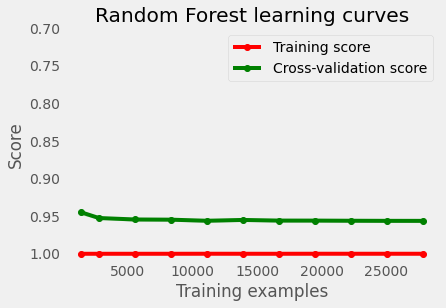

In [39]:
g = plf.plot_learning_curve(rf.grid.best_estimator_, "Random Forest learning curves", X_train, y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

In [40]:
tr = ml.Class_Fit(clf = DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X = X_train, Y = y_train)
tr.grid_predict(X_test, y_test)

Precision: 79.71 %  
 ROC Score: 0.80

               precision    recall  f1-score   support

           0       0.80      0.79      0.80      7423
           1       0.80      0.80      0.80      7472

    accuracy                           0.80     14895
   macro avg       0.80      0.80      0.80     14895
weighted avg       0.80      0.80      0.80     14895



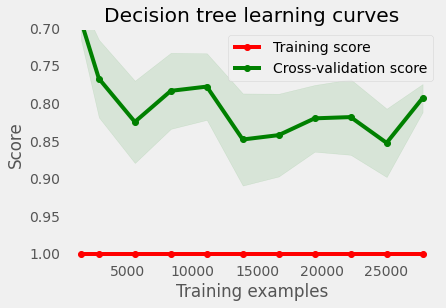

In [41]:
g = plf.plot_learning_curve(tr.grid.best_estimator_, "Decision tree learning curves", X_train, y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

In [42]:
ada = ml.Class_Fit(clf = AdaBoostClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
ada.grid_search(parameters = param_grid, Kfold = 5)
ada.grid_fit(X = X_train, Y = y_train)
ada.grid_predict(X_test, y_test)

Precision: 95.64 %  
 ROC Score: 0.96

               precision    recall  f1-score   support

           0       0.92      1.00      0.96      7423
           1       1.00      0.91      0.95      7472

    accuracy                           0.96     14895
   macro avg       0.96      0.96      0.96     14895
weighted avg       0.96      0.96      0.96     14895



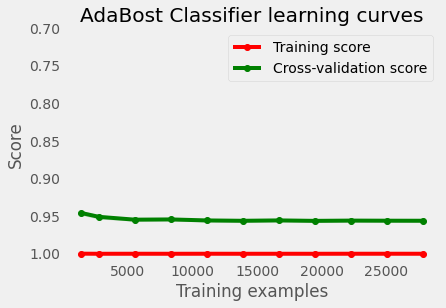

In [43]:
g = plf.plot_learning_curve(rf.grid.best_estimator_, "AdaBost Classifier learning curves", X_train, y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])


In [44]:
gb = ml.Class_Fit(clf = GradientBoostingClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters = param_grid, Kfold = 5)
gb.grid_fit(X = X_train, Y = y_train)
gb.grid_predict(X_test, y_test)

Precision: 95.64 %  
 ROC Score: 0.96

               precision    recall  f1-score   support

           0       0.92      1.00      0.96      7423
           1       1.00      0.91      0.95      7472

    accuracy                           0.96     14895
   macro avg       0.96      0.96      0.96     14895
weighted avg       0.96      0.96      0.96     14895



In [45]:
rf_best  = RandomForestClassifier(**rf.grid.best_params_)
gb_best  = GradientBoostingClassifier(**gb.grid.best_params_)
tr_best  = DecisionTreeClassifier(**tr.grid.best_params_)
ada_best = AdaBoostClassifier(**ada.grid.best_params_)
lr_best  = LogisticRegression(**lr.grid.best_params_)

In [46]:
from sklearn.ensemble import StackingClassifier

In [47]:
stacking = StackingClassifier(estimators=[('rf', rf_best),('lr',lr_best),('gb', gb_best)],
                              final_estimator =ada_best , cv = 5,n_jobs = -1)

In [48]:
stacking = stacking.fit(X_train, y_train)

In [49]:
predictions = stacking.predict(X_test)
print("Precision: {:.2f} % ".format(100*accuracy_score(y_test, predictions)))

Precision: 95.62 % 


# Neural Netwoks

In [50]:
import tensorflow as tf
from tensorflow import keras 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix
from tensorflow import keras as ks

from tensorflow.keras.constraints import max_norm
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_crossentropy


In [51]:
EarlyStop = EarlyStopping(monitor='accuracy', mode='min', patience=10)
BATCH_SIZE = 64
STEPS_PER_EPOCH = len(X_train)//BATCH_SIZE
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        0.0001,
        decay_steps=STEPS_PER_EPOCH*1000,
        decay_rate=1,
        staircase=False)
n_inputs = X_train.shape[1]

inputs = keras.layers.Input(n_inputs)
x = BatchNormalization()(inputs)
x = Dense(30, kernel_initializer='normal',  kernel_constraint=max_norm(2.) ,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                              bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)) (x)
x = BatchNormalization()(x)
x = Dense(20, kernel_initializer='normal',  kernel_constraint=max_norm(2.) ,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                              bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)) (x)
x = BatchNormalization()(x)
x = Dense(10, kernel_initializer='normal',  kernel_constraint=max_norm(2.) ,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                              bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)) (x)
output = Dense(2,activation = "softmax",name ="output")(x)

undersample_model = keras.Model(inputs=inputs, outputs=[output], name="final")

In [52]:
undersample_model.summary()

Model: "final"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 238)]             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 238)               952       
_________________________________________________________________
dense (Dense)                (None, 30)                7170      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30)                120       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                620       
_________________________________________________________________
batch_normalization_2 (Batch (None, 20)                80        
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210   

In [53]:
undersample_model.compile(ks.optimizers.Adam(lr_schedule), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [55]:
undersample_model.fit(X_train, y_train, validation_split=0.2, batch_size=64, epochs=100, shuffle=True,verbose = 2, callbacks = [EarlyStop])


Epoch 1/100
435/435 - 3s - loss: 0.6317 - accuracy: 0.6598 - val_loss: 0.5670 - val_accuracy: 0.7452
Epoch 2/100
435/435 - 1s - loss: 0.4262 - accuracy: 0.8169 - val_loss: 0.3798 - val_accuracy: 0.8364
Epoch 3/100
435/435 - 1s - loss: 0.3040 - accuracy: 0.8774 - val_loss: 0.3096 - val_accuracy: 0.8741
Epoch 4/100
435/435 - 1s - loss: 0.2559 - accuracy: 0.8993 - val_loss: 0.2749 - val_accuracy: 0.8933
Epoch 5/100
435/435 - 1s - loss: 0.2307 - accuracy: 0.9119 - val_loss: 0.2505 - val_accuracy: 0.9040
Epoch 6/100
435/435 - 1s - loss: 0.2154 - accuracy: 0.9193 - val_loss: 0.2435 - val_accuracy: 0.9098
Epoch 7/100
435/435 - 1s - loss: 0.2066 - accuracy: 0.9234 - val_loss: 0.2333 - val_accuracy: 0.9130
Epoch 8/100
435/435 - 1s - loss: 0.1986 - accuracy: 0.9277 - val_loss: 0.2225 - val_accuracy: 0.9190
Epoch 9/100
435/435 - 1s - loss: 0.1949 - accuracy: 0.9305 - val_loss: 0.2196 - val_accuracy: 0.9213
Epoch 10/100
435/435 - 1s - loss: 0.1892 - accuracy: 0.9323 - val_loss: 0.2182 - val_accura

In [56]:
undersample_model.evaluate(X_test,y_test)

466/466 [==============================] - 1s 1ms/step - loss: 0.2091 - accuracy: 0.9276


[0.2091108113527298, 0.9275595545768738]

## Choose the Best and submit

But before we submit, we perfoming a training in all dataset

In [57]:
stacking = stacking.fit(train, train_labels)
undersample_model.fit(train, train_labels, validation_split=0.2, batch_size=64, epochs=100, shuffle=True, verbose=2,callbacks=[EarlyStop])

pred_ml = stacking.predict_proba(test)[:, 1]
pred_dl = undersample_model.predict(test)[:, 1]

Epoch 1/100
621/621 - 1s - loss: 0.1936 - accuracy: 0.9301 - val_loss: 0.1978 - val_accuracy: 0.9334
Epoch 2/100
621/621 - 1s - loss: 0.1889 - accuracy: 0.9314 - val_loss: 0.1962 - val_accuracy: 0.9347
Epoch 3/100
621/621 - 1s - loss: 0.1869 - accuracy: 0.9329 - val_loss: 0.1959 - val_accuracy: 0.9343
Epoch 4/100
621/621 - 1s - loss: 0.1843 - accuracy: 0.9346 - val_loss: 0.2018 - val_accuracy: 0.9349
Epoch 5/100
621/621 - 1s - loss: 0.1811 - accuracy: 0.9357 - val_loss: 0.1947 - val_accuracy: 0.9350
Epoch 6/100
621/621 - 1s - loss: 0.1771 - accuracy: 0.9370 - val_loss: 0.1962 - val_accuracy: 0.9374
Epoch 7/100
621/621 - 1s - loss: 0.1765 - accuracy: 0.9380 - val_loss: 0.1929 - val_accuracy: 0.9369
Epoch 8/100
621/621 - 1s - loss: 0.1768 - accuracy: 0.9369 - val_loss: 0.1927 - val_accuracy: 0.9370
Epoch 9/100
621/621 - 1s - loss: 0.1746 - accuracy: 0.9376 - val_loss: 0.1907 - val_accuracy: 0.9372
Epoch 10/100
621/621 - 1s - loss: 0.1767 - accuracy: 0.9361 - val_loss: 0.1895 - val_accura

In [63]:
pred_ml

array([0.40824902, 0.43082175, 0.38517662, ..., 0.97732975, 0.97732975,
       0.97732975])

In [62]:
submit.head()

,SK_ID_CURR,TARGET
0,100001,0.014539
1,100005,0.093698
2,100013,0.004423
3,100028,0.014603
4,100038,0.094629


In [58]:
# Make a submission dataframe
submit = new[['SK_ID_CURR']]
submit['TARGET'] = pred_ml

# Save the submission dataframe
submit.to_csv('submission_stack.csv', index = False)

# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = pred_dl

# Save the submission dataframe
submit.to_csv('submission_nn.csv', index = False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [61]:
! kaggle competitions submit -c home-credit-default-risk -f submission_stack.csv -m  "Stacking Tecnique"

100% 1.21M/1.21M [00:06<00:00, 200kB/s]
Successfully submitted to Home Credit Default Risk

In [ ]:
! kaggle competitions submit -c home-credit-default-risk -f submission_nn.csv -m "ANN techinique"